# Facemask Emotion Detection
### By Zachary Chin, Harshika Jha, Ryan Root, and Allen Shufer

In [8]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import seaborn as sns

import cv2
import os

import numpy as np

In [2]:
# uses the FER-2013 dataset of facial emotions https://www.kaggle.com/datasets/msambare/fer2013
#   then, used the MaskTheFace by ageelanwar to apply randomized masks to each face https://github.com/aqeelanwar/MaskTheFace
!git clone https://github.com/zachchin/facemask_emotion_detection.git

Cloning into 'facemask_emotion_detection'...
remote: Enumerating objects: 58833, done.
remote: Total 58833 (delta 0), reused 0 (delta 0), pack-reused 58833
Receiving objects: 100% (58833/58833), 100.28 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (60845/60845), done.


In [2]:
train_path = 'facemask_emotion_detection\\archive\\train'
test_path = 'facemask_emotion_detection\\archive\\test'

In [ ]:
!ls facemask_emotion_detection/archive/train/

angry	      disgust_masked  happy	    neutral_masked  surprise
angry_masked  fear	      happy_masked  sad		    surprise_masked
disgust       fear_masked     neutral	    sad_masked


## Display some images with and without facemasks applied to them

Text(0.5, 1.0, 'surprise')

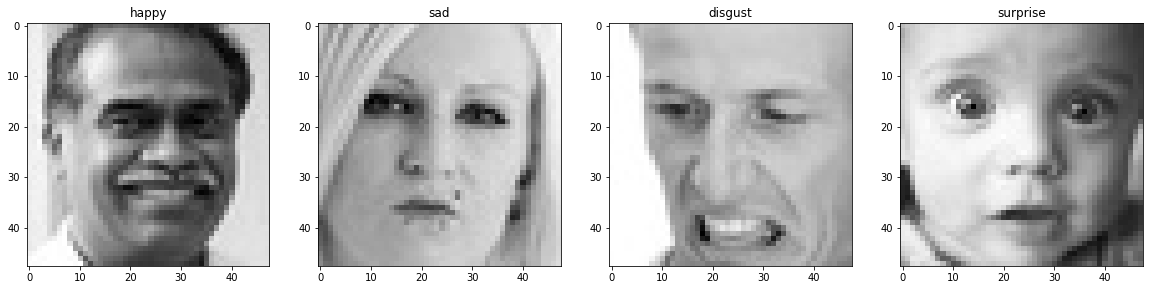

In [ ]:
happy = cv2.imread(train_path + '/happy/Training_99976548.jpg', cv2.IMREAD_GRAYSCALE)
sad = cv2.imread(train_path + '/sad/Training_131185.jpg', cv2.IMREAD_GRAYSCALE)
disgust = cv2.imread(train_path + '/disgust/Training_1070239.jpg', cv2.IMREAD_GRAYSCALE)
surprise = cv2.imread(train_path + '/surprise/Training_353184.jpg', cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(happy, cmap='gray')
axs[0].set_title('happy')
axs[1].imshow(sad, cmap='gray')
axs[1].set_title('sad')
axs[2].imshow(disgust, cmap='gray')
axs[2].set_title('disgust')
axs[3].imshow(surprise, cmap='gray')
axs[3].set_title('surprise')

Text(0.5, 1.0, 'surprise masked')

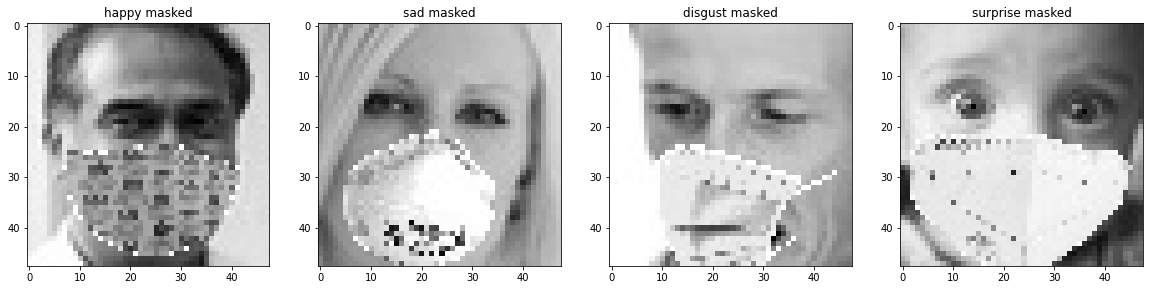

In [ ]:
happy_masked = cv2.imread(train_path + '/happy_masked/Training_99976548_cloth.jpg', cv2.IMREAD_GRAYSCALE)
sad_masked = cv2.imread(train_path + '/sad_masked/Training_131185_N95.jpg', cv2.IMREAD_GRAYSCALE)
disgust_masked = cv2.imread(train_path + '/disgust_masked/Training_1070239_surgical_green.jpg', cv2.IMREAD_GRAYSCALE)
surprise_masked = cv2.imread(train_path + '/surprise_masked/Training_353184_KN95.jpg', cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(happy_masked, cmap='gray')
axs[0].set_title('happy masked')
axs[1].imshow(sad_masked, cmap='gray')
axs[1].set_title('sad masked')
axs[2].imshow(disgust_masked, cmap='gray')
axs[2].set_title('disgust masked')
axs[3].imshow(surprise_masked, cmap='gray')
axs[3].set_title('surprise masked')

Judging from these pictures alone, we can already see that emotion detection with facemasks is going to be an incredibly difficult task to learn. We can hope to be able to at least predict positive vs negative emotions in the end.

## Model

In [4]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
positive = set(['happy', 'neutral', 'surprise'])
negative = set(['angry', 'disgust', 'fear', 'sad'])
img_size = 48
def extract_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label + '_masked')
        class_num = 1 if label in negative else 0
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train_set = extract_data(train_path)
val_set = extract_data(test_path)

<ipython-input-4-c2132c6e8bf0>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [5]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train_set:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val_set:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [6]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(48,48,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

model.summary()

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

C:\Users\dude0\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
625/625 [==============================] - 35s 56ms/step - loss: 0.6781 - accuracy: 0.5840 - val_loss: 0.6702 - val_accuracy: 0.5897
Epoch 2/50
625/625 [==============================] - 36s 58ms/step - loss: 0.6670 - accuracy: 0.5964 - val_loss: 0.6576 - val_accuracy: 0.6217
Epoch 3/50
625/625 [==============================] - 38s 60ms/step - loss: 0.6587 - accuracy: 0.6153 - val_loss: 0.6511 - val_accuracy: 0.6223
Epoch 4/50
625/625 [==============================] - 39s 63ms/step - loss: 0.6534 - accuracy: 0.6223 - val_loss: 0.6460 - val_accuracy: 0.6310
Epoch 5/50
625/625 [==============================] - 42s 68ms/step - loss: 0.6484 - accuracy: 0.6289 - val_loss: 0.6416 - val_accuracy: 0.6340
Epoch 6/50
625/625 [==============================] - 44s 71ms/step - loss: 0.6438 - accuracy: 0.6335 - val_loss: 0.6365 - val_accuracy: 0.6407
Epoch 7/50
625/625 [==============================] - 40s 65ms/step - loss: 0.6387 - accuracy: 0.6385 - val_loss: 0.6385 - val_accuracy:

              precision    recall  f1-score   support

    Positive       0.73      0.81      0.77      2923
    Negative       0.67      0.58      0.62      2039

    accuracy                           0.71      4962
   macro avg       0.70      0.69      0.69      4962
weighted avg       0.71      0.71      0.71      4962



<AxesSubplot:>

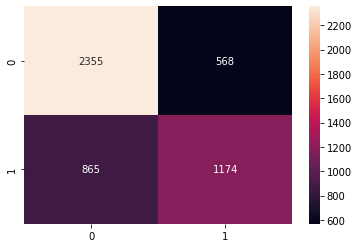

In [11]:
predictions = model.predict(x_val)
predictions = [p[1] for p in predictions]
predictions = np.round(predictions)
print(classification_report(y_val, predictions, target_names=['Positive', 'Negative']))
c_matrix = confusion_matrix(y_val, predictions)
sns.heatmap(c_matrix, annot=True, fmt="d")